# Applied Data Science Capstone

This is the notebook for the Coursera course 'Applied Data Science Capstone'

In [1]:
#!conda install -c conda-forge geopy --yes

In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import geocoder
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Gather Data

In [3]:
# Download url and save to variable 'url'
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
data  = requests.get(url).text 

In [4]:
soup = BeautifulSoup(data,"html5lib")  # create a soup object using the variable 'data'

In [5]:
# Find tbody inside table
tbody = soup.find_all('tbody')

In [6]:
toronto_df = pd.DataFrame(columns = ['PostalCode', 'Borough', 'Neighborhood'])

for row in tbody[0].find_all('tr')[1:]:
        cols = row.find_all('td')
        postal_code = str(cols[0])[4:-6]
        borough = str(cols[1])[4:-6]
        neighborhood = str(cols[2])[4:-6]
            
        toronto_df = toronto_df.append({'PostalCode' : postal_code, 'Borough' : borough, 'Neighborhood' : neighborhood }, ignore_index = True)

In [7]:
#remove rows that have 'Not assigned' values in the column 'Borough', then reset index.
toronto_df = toronto_df.query('Borough != "Not assigned"')
toronto_df.reset_index(inplace = True, drop = True)

In [8]:
toronto_df.shape

(103, 3)

In [9]:
# put 'toronto_df' columns in order of postal code and reset index
toronto_df.sort_values(by = ['PostalCode'], inplace = True)
toronto_df.reset_index(inplace = True, drop = True)

In [10]:
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [11]:
# Read CSV of lat and long coords
lat_long_df = pd.read_csv('https://cocl.us/Geospatial_data')

In [12]:
# put 'lat_long_df' columns in order of postal code and reset index
lat_long_df.sort_values(by = ['Postal Code'], inplace = True)
lat_long_df.reset_index(inplace = True, drop = True)

In [13]:
# Add latitude and longitude columns to 'toronto_df'
toronto_df[['Latitude', 'Longitude']] = lat_long_df[['Latitude', 'Longitude']]

In [14]:
toronto_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [40]:
CLIENT_ID = 'REDACTED' # your Foursquare ID
CLIENT_SECRET = 'REDACTED' # your Foursquare Secret
VERSION = 'REDACTED' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: REDACTED
CLIENT_SECRET:REDACTED


In [ ]:
# function to get all venues within 500 meter radius for all neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# calling 'getNearbyVenues' function for Toronto neighborhoods
toronto_venues = getNearbyVenues(names = toronto_df['Neighborhood'],
                                latitudes = toronto_df['Latitude'],
                                longitudes = toronto_df['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

# 2. Feature Engineering

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [19]:
# Group neighborhoods by the mean frequency of each catagory.
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()


In [20]:
# function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
# create new dataframe that contains top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Clothing Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Pool,Gym,Coffee Shop,Skating Rink,Pharmacy,Pub,Sandwich Place,Women's Store,Deli / Bodega
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Middle Eastern Restaurant,Pharmacy,Supermarket,Sushi Restaurant,Restaurant,Deli / Bodega,Shopping Mall,Mobile Phone Shop
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Juice Bar,Pharmacy,Pub,Sushi Restaurant,Restaurant,Indian Restaurant,Fast Food Restaurant


In [22]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Clothing Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Pool,Gym,Coffee Shop,Skating Rink,Pharmacy,Pub,Sandwich Place,Women's Store,Deli / Bodega
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Middle Eastern Restaurant,Pharmacy,Supermarket,Sushi Restaurant,Restaurant,Deli / Bodega,Shopping Mall,Mobile Phone Shop
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Juice Bar,Pharmacy,Pub,Sushi Restaurant,Restaurant,Indian Restaurant,Fast Food Restaurant
5,Berczy Park,Coffee Shop,Bakery,Cocktail Bar,Farmers Market,Beer Bar,Seafood Restaurant,Pharmacy,Cheese Shop,Restaurant,Bistro
6,"Birch Cliff, Cliffside West",Café,Skating Rink,General Entertainment,College Stadium,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Deli / Bodega
7,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Office,Convenience Store,Bar,Italian Restaurant,Bakery,Stadium,Climbing Gym
8,"Business reply mail Processing Centre, South C...",Gym / Fitness Center,Brewery,Auto Workshop,Burrito Place,Fast Food Restaurant,Garden,Farmers Market,Garden Center,Pizza Place,Comic Shop
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Boat or Ferry,Harbor / Marina,Rental Car Location,Plane,Coffee Shop,Sculpture Garden,Bar,Airport Terminal


# Cluster Results

In [23]:
# function for elbow method for kmeans
# plot = False will return distortion list. plot = True will return nothing
# credit https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
def elbow_method(df, max_clusters, plot = True):
    inertias = []
    distortions = []
    clusters = list(range(1, max_clusters + 1))
    for k in clusters:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        inertias.append(kmeanModel.inertia_)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / df.shape[0])
    if plot == True:
        # plot elbow
        fig, axs = plt.subplots(2)
        axs[0].plot(clusters, distortions, 'bx-')
        axs[1].plot(clusters, inertias, 'bx-')
        axs[1].set_xlabel('k')
        axs[0].set_ylabel('Distortion')
        axs[1].set_ylabel('Inertias')
        axs[0].set_title('The Elbow Method showing the optimal k')
        
        plt.show()
    else:
        return distortions

In [24]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

In [25]:
toronto_grouped_clustering

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0

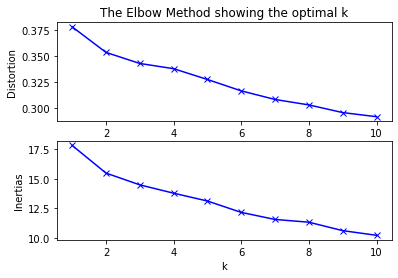

In [26]:
elbow_method(df = toronto_grouped_clustering, max_clusters = 10, plot = True)

Run k-means clusterer to create 5 clusters

In [27]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [28]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 4, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 0, 1, 1, 1, 1, 0, 1])

Create dataframe that combines top 10 venues with cluster results

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2.0,Fast Food Restaurant,Women's Store,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1.0,Home Service,Bar,Women's Store,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dessert Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Electronics Store,Intersection,Restaurant,Rental Car Location,Mexican Restaurant,Bank,Medical Center,Breakfast Spot,Doner Restaurant,Dog Run
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Korean BBQ Restaurant,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Dumpling Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Fried Chicken Joint,Gas Station,Hakka Restaurant,Bakery,Bank,Thai Restaurant,Athletics & Sports,Caribbean Restaurant,Dim Sum Restaurant,Diner


In [30]:
#drop postal codes that do not contain venues 
toronto_merged.dropna(axis = 0, how = 'any', inplace = True)

In [31]:
#reset index after row drop
toronto_merged.reset_index(inplace = True, drop = True)

In [32]:
# convert column 'Cluster Labels' from float to int
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

Get coordinates of Toronto

In [33]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


Create map of relsulting clusters

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Analyze Clusters

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,0,Park,Intersection,Playground,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
20,North York,0,Park,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
22,North York,0,Convenience Store,Park,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
24,North York,0,Park,Food & Drink Shop,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
39,East York,0,Convenience Store,Park,Intersection,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
43,Central Toronto,0,Park,Bus Line,Swim School,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Ethiopian Restaurant
47,Central Toronto,0,Park,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
49,Downtown Toronto,0,Park,Playground,Trail,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
73,York,0,Park,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop


In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,1,Home Service,Bar,Women's Store,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dessert Shop
2,Scarborough,1,Electronics Store,Intersection,Restaurant,Rental Car Location,Mexican Restaurant,Bank,Medical Center,Breakfast Spot,Doner Restaurant,Dog Run
3,Scarborough,1,Coffee Shop,Korean BBQ Restaurant,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Dumpling Restaurant
4,Scarborough,1,Fried Chicken Joint,Gas Station,Hakka Restaurant,Bakery,Bank,Thai Restaurant,Athletics & Sports,Caribbean Restaurant,Dim Sum Restaurant,Diner
5,Scarborough,1,Grocery Store,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
6,Scarborough,1,Hobby Shop,Bus Station,Coffee Shop,Discount Store,Department Store,Doner Restaurant,Dim Sum Restaurant,Diner,Distribution Center,Dog Run
7,Scarborough,1,Bus Line,Bakery,Park,Ice Cream Shop,Bus Station,Intersection,Soccer Field,Construction & Landscaping,Convenience Store,Escape Room
8,Scarborough,1,American Restaurant,Motel,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store
9,Scarborough,1,Café,Skating Rink,General Entertainment,College Stadium,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Deli / Bodega
10,Scarborough,1,Indian Restaurant,Chinese Restaurant,Light Rail Station,Pet Store,Vietnamese Restaurant,Thrift / Vintage Store,Brewery,Women's Store,Diner,Discount Store


In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,2,Fast Food Restaurant,Women's Store,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant


In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
92,Etobicoke,3,Bakery,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Falafel Restaurant


In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
90,Etobicoke,4,Breakfast Spot,Construction & Landscaping,Baseball Field,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Women's Store
95,North York,4,Baseball Field,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Falafel Restaurant


For this analysis, I decided to analyze the top venues for each neighborhood in the city of Toronto, Canada. I then clustered the neigborhoods together. Cluster 0 contains mostly playgrounds and other public accomidations. This is most likely City land that has been turned into a public commons. Cluster 1 contains the lion's share of the neighborhoods. It is made up of mostly restraunts, bars, and gorcery stores. There is also a high concentration of cluster 1 venues in the downtown area. Cluster 2 and 3 are similar in content and only contain 1 neighborhood each. The same goes for cluster 4. Therfore, there is very little data to go on there.